In [2]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator


# Set up plotting style
#plt.style.use('seaborn')

In [3]:
# Load your BACE1 inhibitor dataset
# Assuming you have a CSV file with SMILES and ChEMBL IDs for BACE1 inhibitors
bace1_df = pd.read_csv("../drug_design_2/ro5_properties_bace1_filtered.csv")
print("Dataframe shape:", bace1_df.shape)
bace1_df.head()

Dataframe shape: (6078, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,429.127089,7,2,2.12408,True
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,435.137653,8,2,1.65600,True
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,455.142739,7,2,2.65828,True
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,455.123895,7,2,2.58500,True
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,442.092261,7,2,2.07520,True


In [4]:
# Create molecules from SMILES and store in array
compounds = []
for _, chembl_id, smiles in bace1_df[["molecule_chembl_id", "smiles"]].itertuples():
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:  # Ensure the SMILES is valid
        compounds.append((mol, chembl_id))

print(f"Number of valid compounds: {len(compounds)}")

Number of valid compounds: 6078


In [5]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, _ in compounds]

print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 6078
Fingerprint length per compound: 2048


In [6]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints"""
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    return sorted(clusters, key=len, reverse=True)

In [7]:
# Run the clustering procedure for the dataset
cutoff = 0.3  # You can adjust this value
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Report on cluster sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print(f"Total # clusters: {len(clusters)}")
print(f"# clusters with only 1 compound: {num_clust_g1}")
print(f"# clusters with >5 compounds: {num_clust_g5}")
print(f"# clusters with >25 compounds: {num_clust_g25}")
print(f"# clusters with >100 compounds: {num_clust_g100}")

Total # clusters: 734
# clusters with only 1 compound: 318
# clusters with >5 compounds: 181
# clusters with >25 compounds: 36
# clusters with >100 compounds: 10


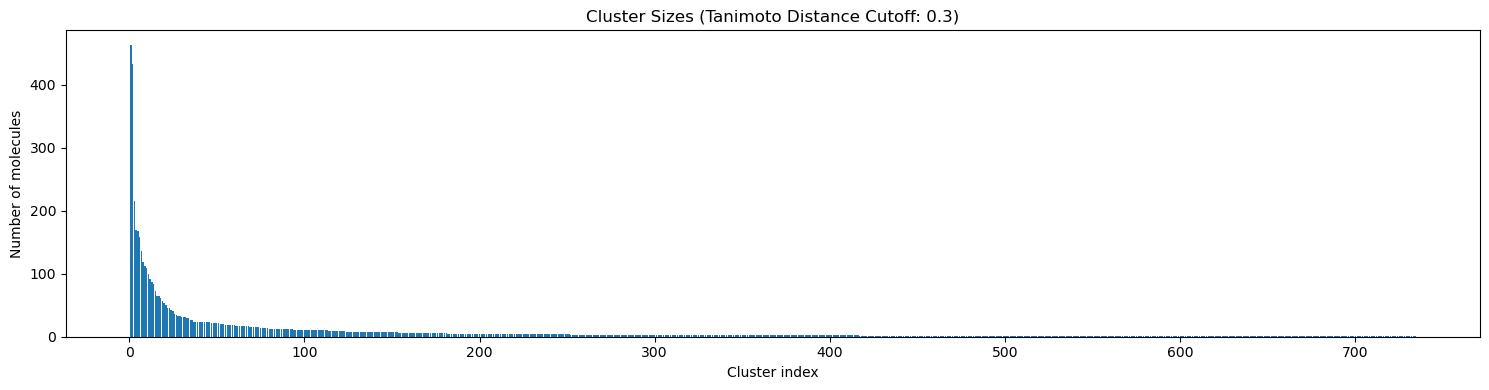

In [8]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
ax.set_title(f"Cluster Sizes (Tanimoto Distance Cutoff: {cutoff})")
plt.tight_layout()
plt.show()

10 molecules from cluster 1:


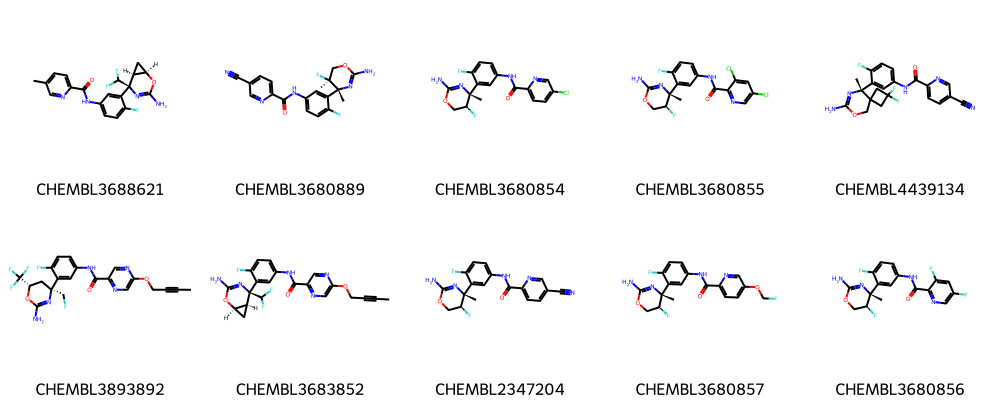

In [9]:
def plot_cluster_molecules(cluster_index, n_molecules=10):
    cluster = clusters[cluster_index]
    n_molecules = min(n_molecules, len(cluster))
    
    print(f"{n_molecules} molecules from cluster {cluster_index + 1}:")
    img = Draw.MolsToGridImage(
        [compounds[i][0] for i in cluster[:n_molecules]],
        legends=[compounds[i][1] for i in cluster[:n_molecules]],
        molsPerRow=5,
        subImgSize=(200, 200)
    )
    return img

# Plot molecules from the largest cluster
plot_cluster_molecules(0)

10 molecules from cluster 2:


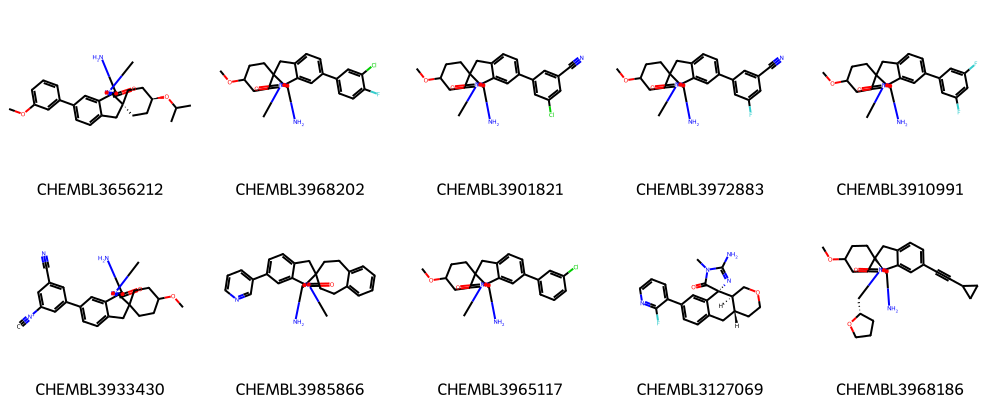

In [10]:
# Plot molecules from the second largest cluster
plot_cluster_molecules(1)

Cluster centers from first 10 clusters:


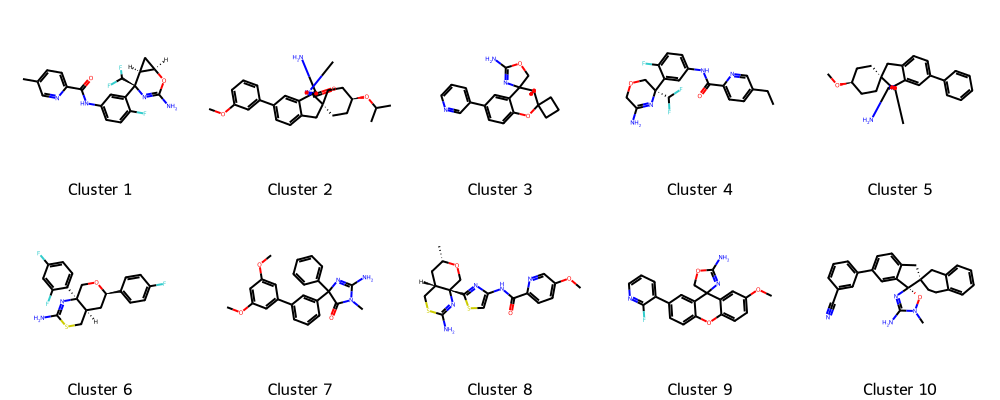

In [11]:
# Plot cluster centers from the first 10 clusters
print("Cluster centers from first 10 clusters:")
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[f"Cluster {i+1}" for i in range(10)],
    molsPerRow=5,
    subImgSize=(200, 200)
)
img

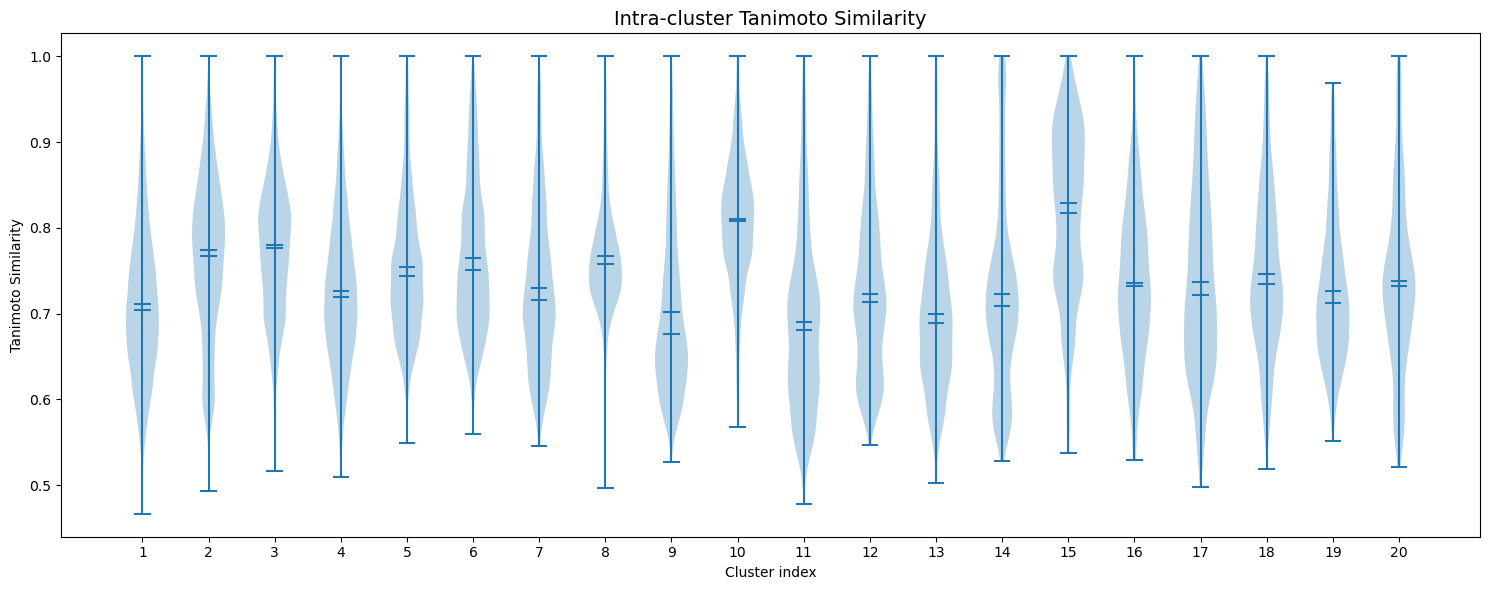

In [12]:
def intra_tanimoto(fps_clusters):
    """Compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    for cluster in fps_clusters:
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

# Compute fingerprints for the first 20 clusters
mol_fps_per_cluster = []
for cluster in clusters[:20]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

# Violin plot with intra-cluster similarity
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Tanimoto Similarity")
ax.set_title("Intra-cluster Tanimoto Similarity", fontsize=14)
vp = ax.violinplot(intra_sim, showmeans=True, showmedians=True)
ax.set_xticks(range(1, 21))
ax.set_xticklabels(range(1, 21))
plt.tight_layout()
plt.show()

In [13]:
def select_diverse_compounds(compounds, clusters, max_compounds=1000):
    cluster_centers = [compounds[c[0]] for c in clusters]
    selected_molecules = cluster_centers.copy()
    
    sorted_clusters = []
    for cluster in clusters:
        if len(cluster) <= 1:
            continue
        sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
        similarities = DataStructs.BulkTanimotoSimilarity(sorted_fingerprints[0], sorted_fingerprints[1:])
        similarities = list(zip(similarities, cluster[1:]))
        similarities.sort(reverse=True)
        sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    sorted_clusters.sort(reverse=True)
    
    index = 0
    pending = max_compounds - len(selected_molecules)
    while pending > 0 and index < len(sorted_clusters):
        tmp_cluster = sorted_clusters[index][1]
        num_compounds = min(10, int(0.5 * len(tmp_cluster)) + 1, pending)
        selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
        index += 1
        pending = max_compounds - len(selected_molecules)
    
    return selected_molecules

diverse_subset = select_diverse_compounds(compounds, clusters)
print(f"Number of selected diverse compounds: {len(diverse_subset)}")

Number of selected diverse compounds: 1000


In [14]:
# Convert the diverse subset to a DataFrame and save it
diverse_df = pd.DataFrame(diverse_subset, columns=['Molecule', 'ChEMBL_ID'])
diverse_df['SMILES'] = diverse_df['Molecule'].apply(lambda x: Chem.MolToSmiles(x))
diverse_df = diverse_df[['ChEMBL_ID', 'SMILES']]
diverse_df.to_csv('bace1_diverse_subset.csv', index=False)
print(diverse_df.head())

       ChEMBL_ID                                             SMILES
0  CHEMBL3688621  Cc1ccc(C(=O)Nc2ccc(F)c([C@@]3(C(F)F)N=C(N)O[C@...
1  CHEMBL3656212  COc1cccc(-c2ccc3c(c2)C2(N=C(N)N(C)C2=O)[C@]2(C...
2  CHEMBL3650837    NC1=NC2(CO1)c1cc(-c3cccnc3)ccc1OC1(CCC1)C21COC1
3  CHEMBL3653482  CCc1ccc(C(=O)Nc2ccc(F)c([C@]3(C(F)F)COCC(N)=N3...
4  CHEMBL3928162  CO[C@H]1CC[C@]2(CC1)Cc1ccc(-c3ccccc3)cc1[C@@]2...


# BACE1 Inhibitor Analysis: Clustering and Diversity Selection

## Introduction

In this notebook, we've performed a clustering analysis of potential BACE1 inhibitors to identify diverse chemical scaffolds. BACE1 (Beta-secretase 1) is a crucial enzyme in the pathogenesis of Alzheimer's disease, making it an important target for drug discovery efforts.

## Methodology

### 1. Data Preparation and Molecule Representation

We started by loading our BACE1 dataset and representing molecules using RDKit molecular objects. This allows for efficient manipulation and analysis of chemical structures.

### 2. Molecular Descriptors and Fingerprints

We calculated RDK fingerprints, which are topological fingerprints that encode structural information about molecules. These fingerprints allow for rapid similarity comparisons between compounds.

### 3. Similarity Calculations

We used the Tanimoto coefficient to quantify the similarity between molecular fingerprints. This metric is widely used in cheminformatics and provides a good balance between sensitivity and specificity.

### 4. Butina Clustering

We employed the Butina clustering algorithm, which is particularly well-suited for chemical similarity clustering. This algorithm creates clusters where each compound has a similarity to the cluster centroid above a specified threshold.

### 5. Cluster Analysis

We analyzed the distribution of cluster sizes and intra-cluster similarities. This helps us understand the diversity of our compound set and identify common structural motifs.

### 6. Diverse Compound Selection

We implemented an algorithm to select a diverse subset of compounds, ensuring representation from all clusters while maintaining diversity.

## Limitations

1. The clustering is based on 2D structural features and doesn't account for 3D conformations or protein-ligand interactions.
2. The choice of fingerprint type and clustering parameters can significantly affect the results.
3. This approach might miss important activity cliffs where small structural changes lead to large changes in activity.

## Possible Next Steps

1. **Integration with Bioactivity Data**: Incorporate known IC50 or Ki values for BACE1 inhibition to identify clusters enriched with highly active compounds.

2. **Molecular Docking**: Perform docking studies on representative compounds from each cluster to understand binding modes.

3. **ADME Property Analysis**: Analyze clusters for desirable ADME properties to prioritize compounds more likely to become successful drugs.

4. **Scaffold Hopping**: Use the diverse set of clusters to inspire new molecular designs that combine features from different structural classes.

5. **Machine Learning Models**: Use the clustering results to train ML models for predicting BACE1 inhibition or to guide the selection of training sets.

6. **Experimental Validation**: Propose representatives from diverse clusters for synthesis and biological testing to validate the clustering results and explore structure-activity relationships.